In [99]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import missingno as msno
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from scipy.stats import probplot, ks_2samp

In [3]:
train= pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
# Выбирем числовые признаки
numerical_features = train.select_dtypes(include=[np.number]).columns
# уберем отуда таргет
numerical_features = numerical_features.drop('isFraud')
# создадим таргет
y_train = train['isFraud']
y_test = test['isFraud']


In [8]:
object_features = train.select_dtypes(include=[np.object]).columns

In [10]:
D={}
for i in object_features:
    d={}
    value_counts=train[i].value_counts()
    for j in value_counts.index:
        d[j]=round(train[train[i]==j]['isFraud'].sum()/value_counts[j],10)*100
    D[i]=d  

In [11]:
train_1=train.copy()
test_1 = test.copy()


In [12]:
for i in D:
    train_1[i] = train_1[i].map(D[i])
    test_1[i] = test_1[i].map(D[i])

Задание 1: Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

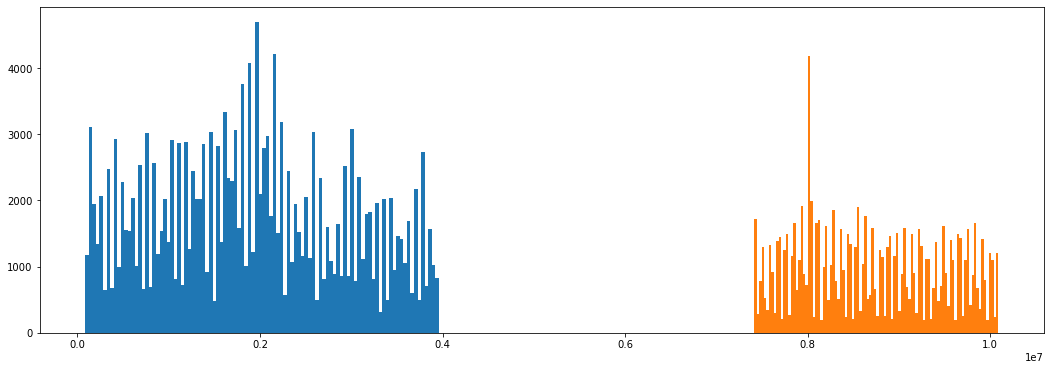

In [28]:
fig = plt.figure(figsize=(18, 6))
plt.hist(train['TransactionDT'],100)
plt.hist(test['TransactionDT'],100)
plt.show()

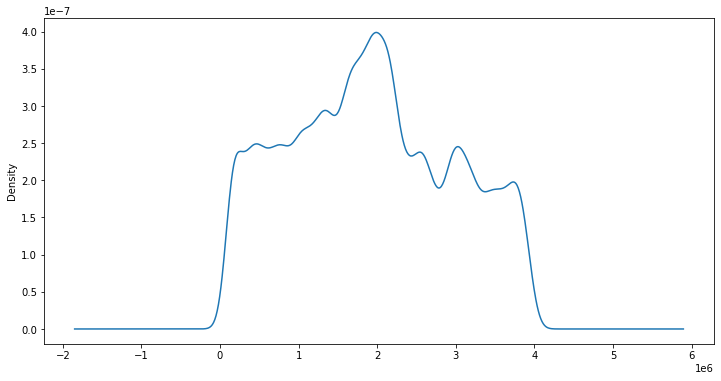

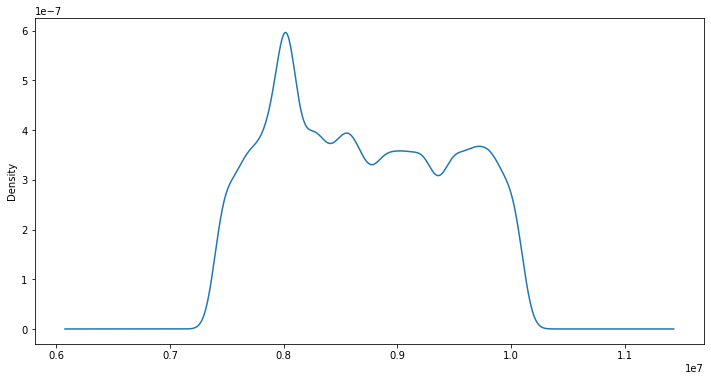

In [81]:
plt.subplots(figsize = (12,6))
train['TransactionDT'].plot.kde()
plt.show()
plt.subplots(figsize = (12,6))
test['TransactionDT'].plot.kde()
plt.show()


    Кроме того , что они из разного временного интервала ничего на ум не приходит. То есть тест, сделан несколько позже трейна

Задание 2: построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

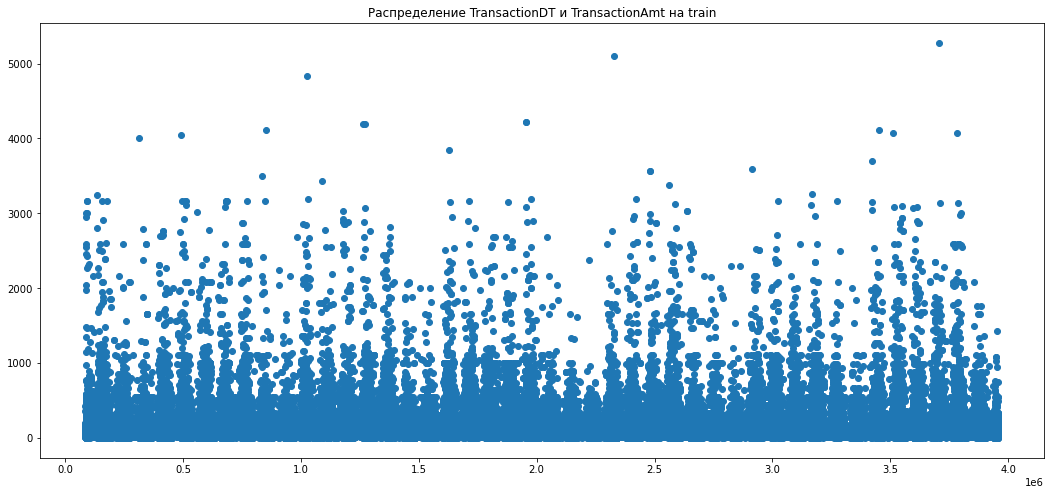

In [62]:
plt.figure(figsize=(18,8))
plt.scatter(train['TransactionDT'],train['TransactionAmt'])
plt.title('Распределение TransactionDT и TransactionAmt на train')
plt.show()

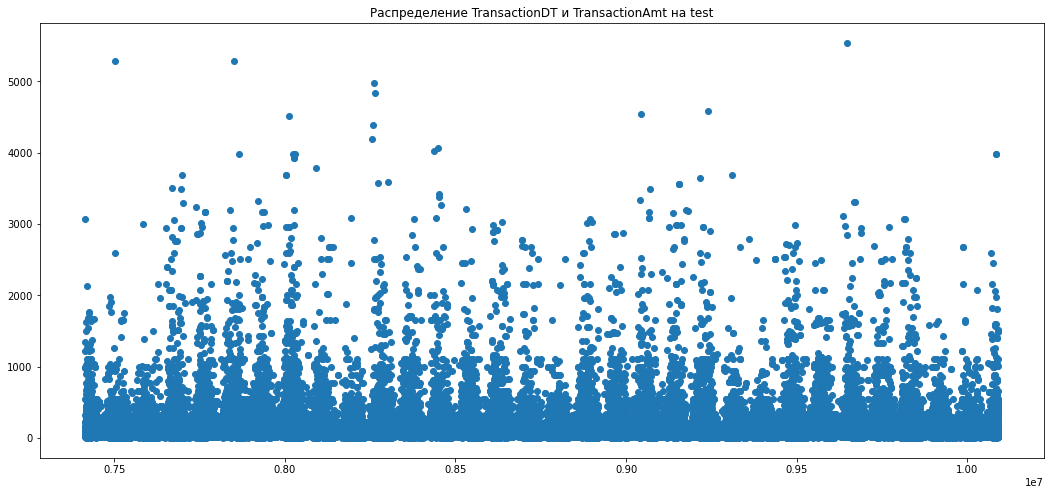

In [63]:
plt.figure(figsize=(18,8))
plt.scatter(test['TransactionDT'],test['TransactionAmt'])
plt.title('Распределение TransactionDT и TransactionAmt на test')
plt.show()

Есть интервалы времени, когда происходят скачки сумм транзакций.Похоже, что эти интервалы симетричные, возможно это какое то время в течении суток. 

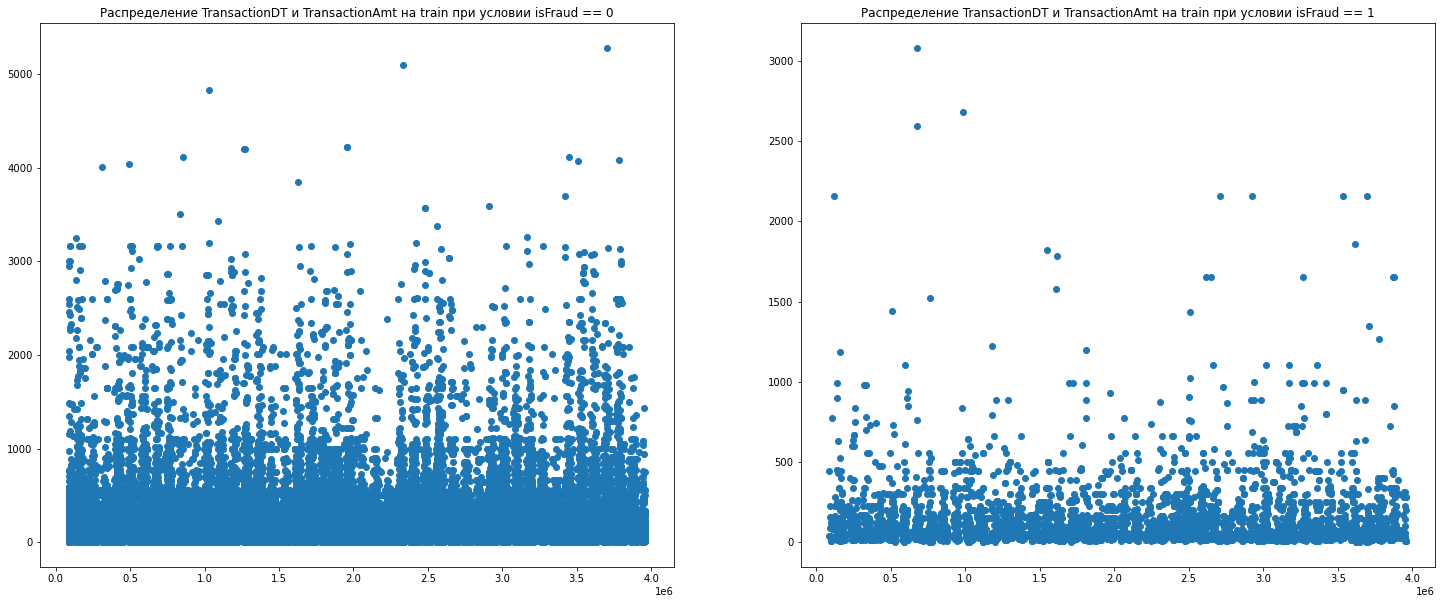

In [71]:
fig,ax = plt.subplots(1, 2, figsize = (25,10))
ax[0].scatter(train[train['isFraud']==0]['TransactionDT'],train[train['isFraud']==0]['TransactionAmt'])
ax[1].scatter(train[train['isFraud']==1]['TransactionDT'],train[train['isFraud']==1]['TransactionAmt'])
ax[0].title.set_text('Распределение TransactionDT и TransactionAmt на train при условии isFraud == 0')
ax[1].title.set_text('Распределение TransactionDT и TransactionAmt на train при условии isFraud == 1')
plt.show()

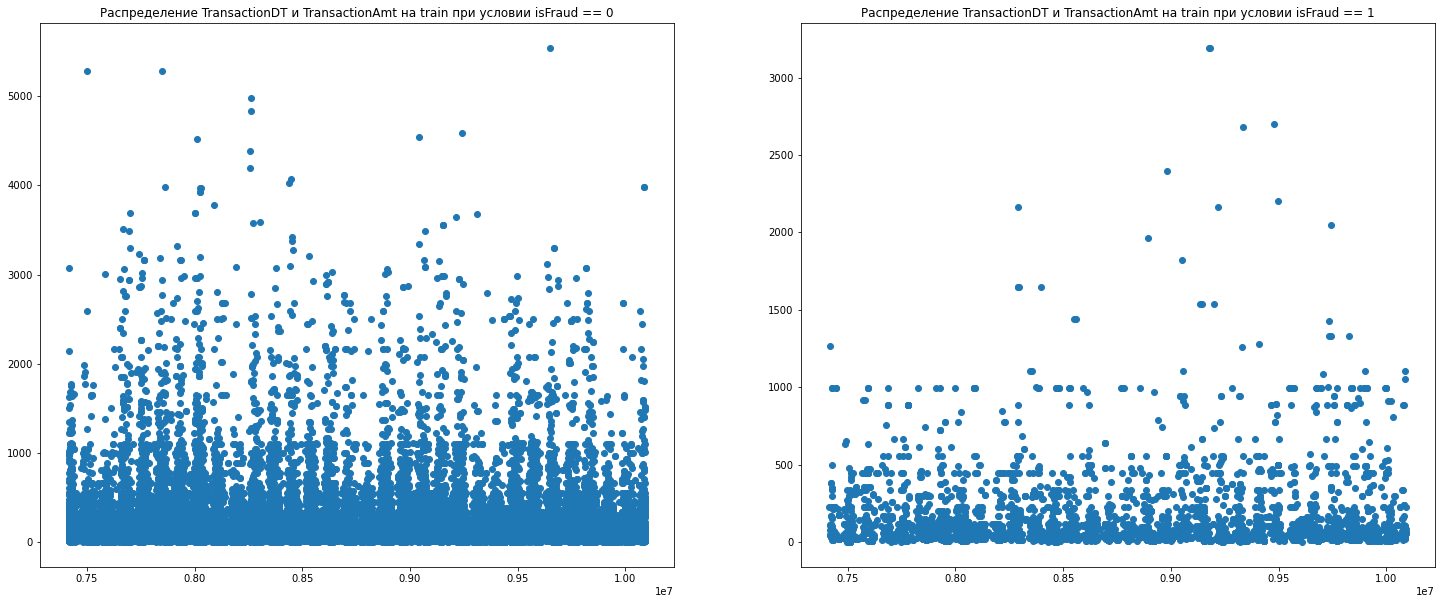

In [72]:
fig,ax = plt.subplots(1, 2, figsize = (25,10))
ax[0].scatter(test[test['isFraud']==0]['TransactionDT'],test[test['isFraud']==0]['TransactionAmt'])
ax[1].scatter(test[test['isFraud']==1]['TransactionDT'],test[test['isFraud']==1]['TransactionAmt'])
ax[0].title.set_text('Распределение TransactionDT и TransactionAmt на train при условии isFraud == 0')
ax[1].title.set_text('Распределение TransactionDT и TransactionAmt на train при условии isFraud == 1')
plt.show()

В целом суммы меньше при положительных тразакциях., интервальность тк же присутвует

Задание 3: построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

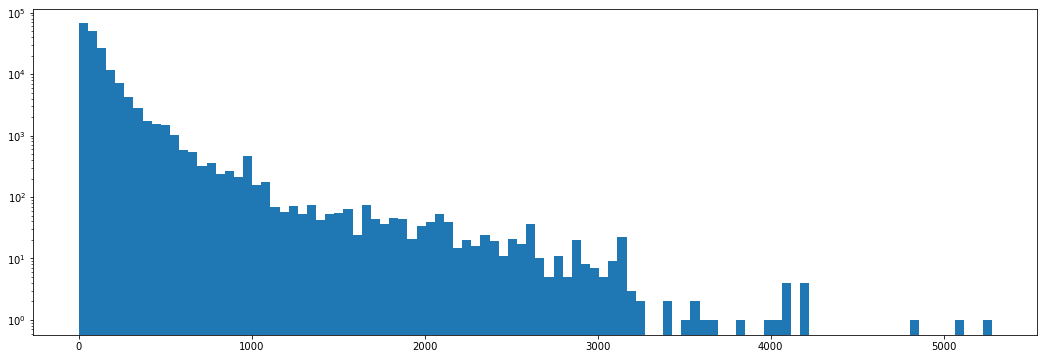

In [78]:
fig = plt.figure(figsize=(18, 6))
plt.hist(train['TransactionAmt'],100,log=True)
plt.show()

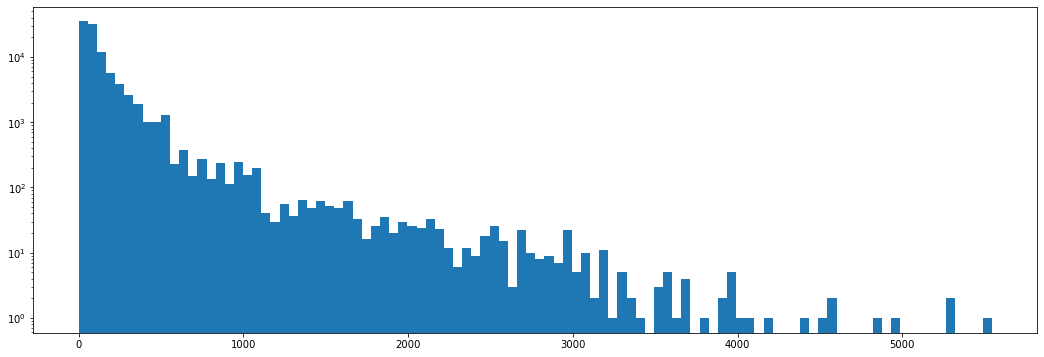

In [79]:
fig = plt.figure(figsize=(18, 6))
plt.hist(test['TransactionAmt'],100,log=True)
plt.show()

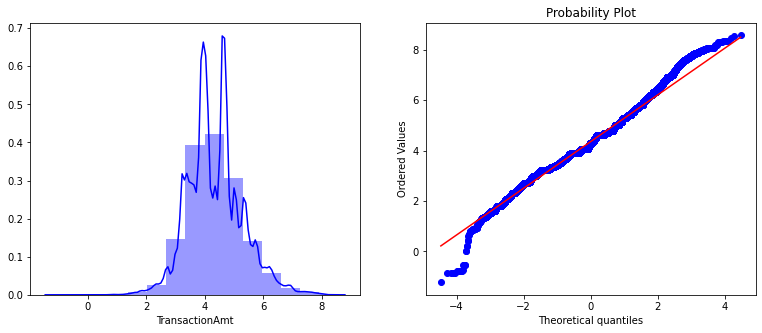

In [103]:
c = np.log(train['TransactionAmt'])
fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.distplot(c, bins=15, color="blue")
plt.subplot(122)
probplot(c, plot=plt)
plt.show()

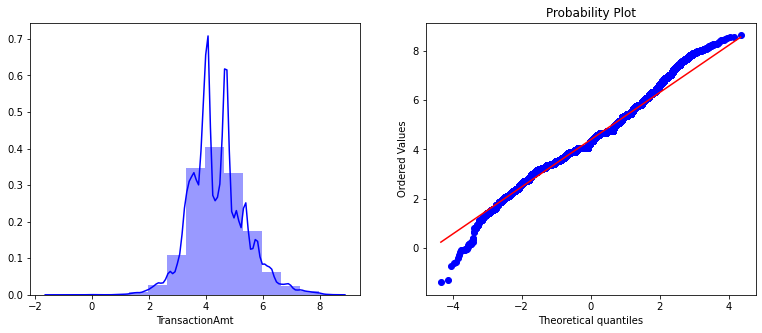

In [101]:
g = np.log(test['TransactionAmt'])
fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.distplot(g, bins=15, color="blue")
plt.subplot(122)
probplot(g, plot=plt)
plt.show()

Задание 4: построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

In [134]:
for_ProductCD = train.groupby('ProductCD').agg({'ProductCD':'count','isFraud':'sum'})
for_ProductCD['q'] = round((for_ProductCD['isFraud']/for_ProductCD['ProductCD'])*100,5)
for_ProductCD.sort_values(by=['q'],ascending =False, inplace=True)
for_ProductCD

,ProductCD,isFraud,q
ProductCD,,,
C,21664,2020,9.32422
S,3648,132,3.61842
H,22422,571,2.54661
W,110340,2046,1.85427
R,21926,372,1.69662


Text(0.5, 1.0, 'Объем ProductCD и объем  положительных исходов в каждой категории ')

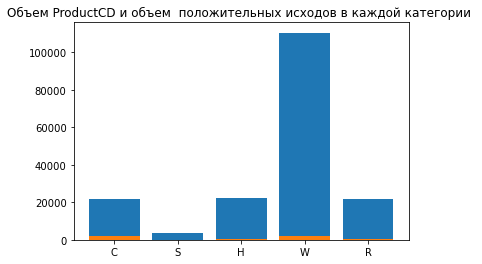

In [139]:
plt.bar(for_ProductCD.index,for_ProductCD['ProductCD'])
plt.bar(for_ProductCD.index,for_ProductCD['isFraud'])
plt.title('Объем ProductCD и объем  положительных исходов в каждой категории ')

Text(0.5, 1.0, 'Доля в % положительных исходов в каждой категории ProductCD')

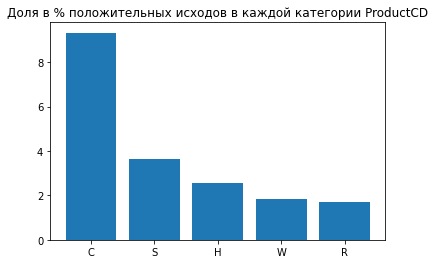

In [137]:
plt.bar(for_ProductCD.index,for_ProductCD['q'])
plt.title('Доля в % положительных исходов в каждой категории ProductCD')

In [141]:
for_card4 = train.groupby('card4').agg({'card4':'count','isFraud':'sum'})
for_card4['q'] = round((for_card4['isFraud']/for_card4['card4'])*100,5)
for_card4.sort_values(by=['q'],ascending =False, inplace=True)
for_card4

,card4,isFraud,q
card4,,,
discover,2378,87,3.65854
mastercard,54501,1744,3.19994
visa,118295,3234,2.73384
american express,4818,74,1.53591


Text(0.5, 1.0, 'Объем платежной системы и объем  положительных исходов в каждой категории ')

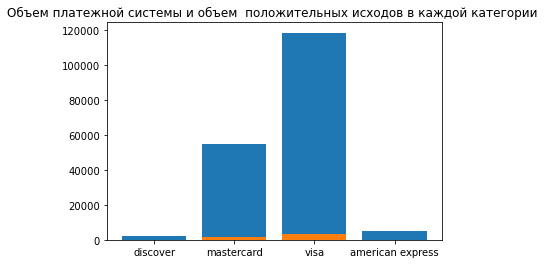

In [143]:
plt.bar(for_card4.index,for_card4['card4'])
plt.bar(for_card4.index,for_card4['isFraud'])
plt.title('Объем платежной системы и объем  положительных исходов в каждой категории ')

Text(0.5, 1.0, 'Доля в % положительных исходов в каждой категории платежной системы')

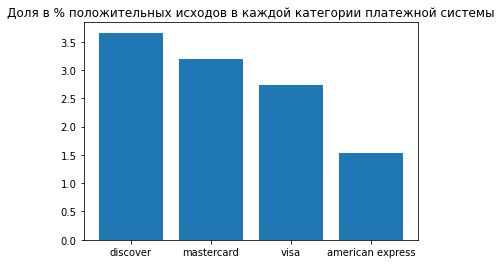

In [144]:
plt.bar(for_card4.index,for_card4['q'])
plt.title('Доля в % положительных исходов в каждой категории платежной системы')

In [145]:
for_card6 = train.groupby('card6').agg({'card6':'count','isFraud':'sum'})
for_card6['q'] = round((for_card6['isFraud']/for_card6['card6'])*100,5)
for_card6.sort_values(by=['q'],ascending =False, inplace=True)
for_card6

,card6,isFraud,q
card6,,,
credit,57229,2545,4.44705
debit,122746,2594,2.11331
charge card,8,0,0.00000
debit or credit,10,0,0.00000


Text(0.5, 1.0, 'Объем вида карты системы и объем  положительных исходов в каждой категории ')

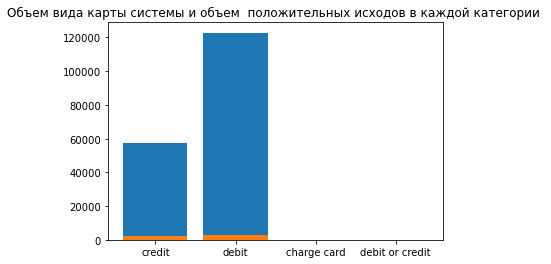

In [146]:
plt.bar(for_card6.index,for_card6['card6'])
plt.bar(for_card6.index,for_card6['isFraud'])
plt.title('Объем вида карты системы и объем  положительных исходов в каждой категории ')

Text(0.5, 1.0, 'Доля в % положительных исходов в каждой категории')

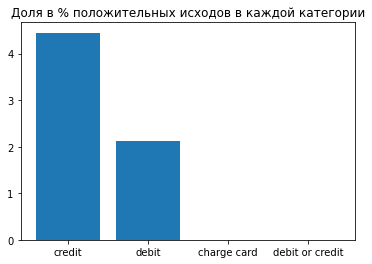

In [147]:
plt.bar(for_card6.index,for_card6['q'])
plt.title('Доля в % положительных исходов в каждой категории')